In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [226]:
df = pd.read_csv(r"../data/VN30F1M_1min_cleaned.csv",parse_dates=[0],index_col=0)

In [227]:
df.columns

Index(['symbol', 'raw_date', 'open', 'close', 'high', 'low',
       'eod_open_interest', 'volume', 'buy_volume', 'sell_volume',
       'day_of_week', 'day_of_year', 'is_month_end', 'is_month_start',
       'is_morning', 'est_average', 'est_trading_val', 'cum_sum_tradingval',
       'cum_sum_volume', 'cum_buy_volume', 'cum_sell_volume'],
      dtype='object')

Text(0.5, 1.0, 'VN30 Futures Prices at 1Min Interval')

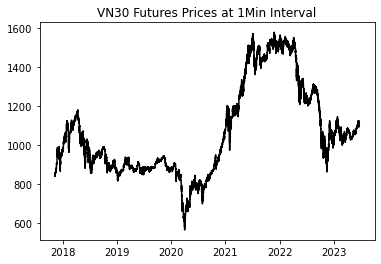

In [77]:
plt.plot(vn30f30m["close"], color = 'black')
plt.title("VN30 Futures Prices at 1Min Interval")

In [222]:
df["close_diff_t1"] = df["close"].diff()
df["close_diff_pct_t1"] = df["close"].pct_change()

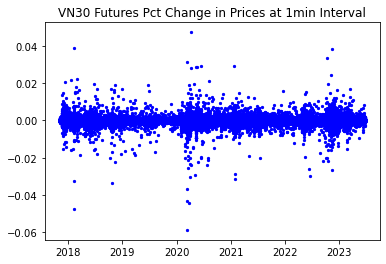

In [220]:
plt.scatter(df.index, df["close_diff_pct_t1"], marker='o', s=5, color='blue')
plt.title("VN30 Futures Pct Change in Prices at 1min Interval")
plt.show()

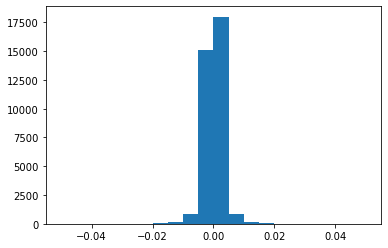

In [152]:
plt.hist(df["close_diff_pct_t1"], bins = 20, range=(-0.05, 0.05))
plt.show()

In [223]:
print("Summary statistics for 30 Min Pct Change")
df["close_diff_pct_t1"].describe()

Summary statistics for 30 Min Pct Change


count    12674.000000
mean         0.000034
std          0.004719
min         -0.058492
25%         -0.001329
50%          0.000000
75%          0.001586
max          0.046656
Name: close_diff_pct_t1, dtype: float64

In [49]:
# Trying to map out the summary statistics for price change half-day (2.5 hours in morning, 1.5 hours in afternoon)
vn30f30m['dates'] = vn30f30m.index.date  # Extract date from timestamp

morning = vn30f30m[(vn30f30m.index.time >= pd.to_datetime('9:00').time()) & (vn30f30m.index.time <= pd.to_datetime('11:30').time())]
afternoon = vn30f30m[(vn30f30m.index.time >= pd.to_datetime('13:00').time()) & (vn30f30m.index.time <= pd.to_datetime('14:30').time())]

daily_change = vn30f30m.groupby('dates').agg({'close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100})
daily_morning_change = morning.groupby('dates').agg({'close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100})
daily_afternoon_change = afternoon.groupby('dates').agg({'close': lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100})

In [58]:
print("Summary statistics for daily price change")
print(daily_change.describe())

print("Summary statistics for daily price change in the morning")
print(daily_morning_change.describe())

print("Summary statistics for daily price change in the afternoon")
print(daily_afternoon_change.describe())

Summary statistics for daily price change
             close
count  1407.000000
mean     -0.016964
std       1.284834
min      -6.329817
25%      -0.563765
50%       0.000000
75%       0.554555
max       9.699849
Summary statistics for daily price change in the morning
             close
count  1407.000000
mean      0.001251
std       0.738745
min      -6.263315
25%      -0.263482
50%      -0.006787
75%       0.294016
max       7.208251
Summary statistics for daily price change in the afternoon
             close
count  1407.000000
mean     -0.019015
std       0.966731
min      -4.568106
25%      -0.435417
50%      -0.033501
75%       0.478612
max       5.741027


### Plotting ACF, PACF and fitting ARIMA model

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

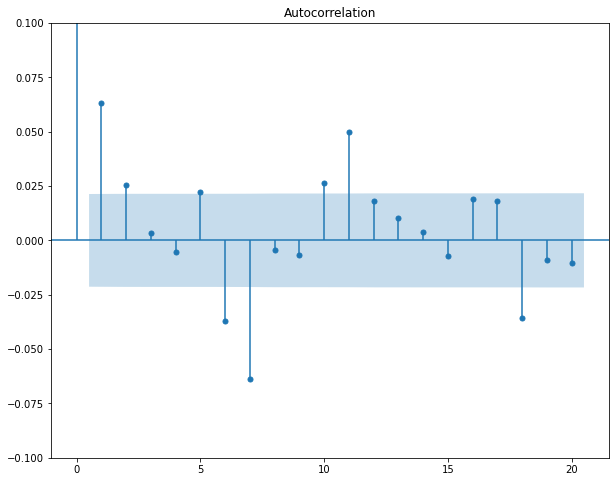

In [206]:
fig, ax1 = plt.subplots(1, figsize=(10,8))
plot_acf(df["close_diff_pct_t1"].dropna(), ax=ax1, lags=20);
ax1.set_ylim(-0.1, 0.1)
plt.show()

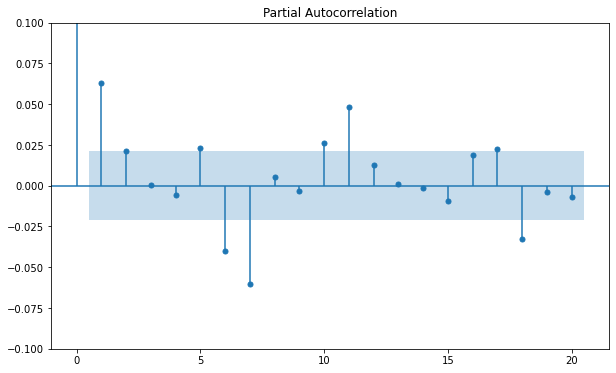

In [207]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, ax1 = plt.subplots(1, figsize=(10,6))
plot_pacf(df["close_diff_pct_t1"].dropna(), ax=ax1, lags=20);
ax1.set_ylim(-0.1, 0.1)
plt.show()

In [210]:
# Estimate the ARIMA differencing term based on Augmented Dickey-Fuller test

from pmdarima.arima.utils import ndiffs
diff_term = ndiffs(df["close_diff_pct_t1"].dropna(), test = "adf")
print("d in ARIMA should be", diff_term)

d in ARIMA should be 0


In [211]:
df["close_diff_pct_t1"]

datetime
2017-11-06 09:00:00         NaN
2017-11-06 10:00:00    0.000238
2017-11-06 11:00:00    0.001427
2017-11-06 12:00:00   -0.000594
2017-11-06 13:00:00    0.000000
                         ...   
2023-06-23 11:00:00    0.002057
2023-06-23 12:00:00   -0.004819
2023-06-23 13:00:00    0.000000
2023-06-23 14:00:00    0.001973
2023-06-23 15:00:00    0.001969
Name: close_diff_pct_t1, Length: 8454, dtype: float64

In [212]:
df = df.dropna(how = "any", axis="rows")

Estimating ARIMA model in (p, d, q) terms.
* p is the number of autoregressive terms; p can be found based on the cut-off point of PACF
* d is the number of nonseasonal differences; d is the number of differencing term.
* q is the number of lagged forecast errors in the prediction equation; q is based on cut-off point of ACF

In [213]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["close_diff_pct_t1"].values, order=(11, 0, 11))
result = model.fit()

print("ARIMA model (11, 0, 11) for VN30F Pct_Change 1 Hour Interval")
print(result.summary())

/Users/nambuismbp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nambuismbp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA model (11, 0, 11) for VN30F Pct_Change 1 Hour Interval
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8453
Model:               ARIMA(11, 0, 11)   Log Likelihood               31439.218
Date:                Fri, 07 Jul 2023   AIC                         -62830.437
Time:                        19:18:47   BIC                         -62661.422
Sample:                             0   HQIC                        -62772.745
                               - 8453                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.776e-05   6.84e-05      0.698      0.485   -8.63e-05       0.000
ar.L1       1.779e-06      0.004      0.000      1.000      -0.007    

In [214]:
from sklearn import metrics


mse = np.sqrt(metrics.mean_squared_error(df["close_diff_pct_t1"], result.fittedvalues))
mae = metrics.mean_absolute_error(df["close_diff_pct_t1"], result.fittedvalues)

print("The mean squared error is:", mse)
print("The mean absolute error is:", mae)

The mean squared error is: 0.005868031222715638
The mean absolute error is: 0.003367557853019799


### Merging with VN30 Data

In [103]:
merged = vn30.merge(vn30f5m, how='left', left_index=True, right_index=True)

In [105]:
merged = merged.dropna(axis=0, how='any')

In [106]:
merged.head(5)

,symbol,raw_date,open_x,close_x,high_x,low_x,open_interest,volume_x,buy_volume_x,sell_volume_x,...,is_month_start,is_morning,est_trading_val,est_average,cum_sum_tradingval,cum_sum_volume,cum_buy_volume,cum_sell_volume,close_diff_t1,close_diff_pct_t1
datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 09:20:00,VN30,20201230 09:19:57,1062.44,1062.43,1062.48,1062.10,0.0,838820.0,0.0,0.0,...,0.0,1.0,3022148.05,1069.40,9065448.40,8488.0,5632.0,2856.0,1.7,0.001591
2020-12-30 09:25:00,VN30,20201230 09:24:58,1064.04,1063.76,1064.04,1063.71,0.0,2108590.0,0.0,0.0,...,0.0,1.0,3058377.95,1070.80,12123826.35,11344.0,7110.0,4234.0,0.2,0.000187
2020-12-30 09:30:00,VN30,20201230 09:29:49,1063.80,1063.84,1063.85,1063.62,0.0,1091320.0,0.0,0.0,...,0.0,1.0,3234235.50,1071.29,15358061.85,14363.0,8772.0,5591.0,1.2,0.001121
2020-12-30 09:35:00,VN30,20201230 09:34:57,1064.43,1064.25,1064.47,1064.25,0.0,1087000.0,0.0,0.0,...,0.0,1.0,1641726.30,1071.62,16999788.15,15895.0,9926.0,5969.0,-0.3,-0.000280
2020-12-30 09:40:00,VN30,20201230 09:39:58,1064.38,1064.59,1064.59,1064.38,0.0,316610.0,0.0,0.0,...,0.0,1.0,1857521.10,1071.26,18857309.25,17629.0,10887.0,6742.0,0.5,0.000467


Text(0.5, 1.0, 'Correlation: 0.9994398957718056')

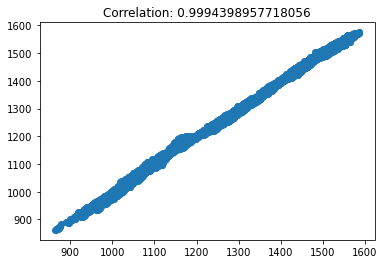

In [107]:
plt.scatter(merged['close_x'], merged['close_y'])
plt.title(f"Correlation: {merged['close_x'].corr(merged['close_y'])}")

In [108]:
merged["diff_basis"] = merged["close_x"] - merged["close_y"]

2.384391816238592

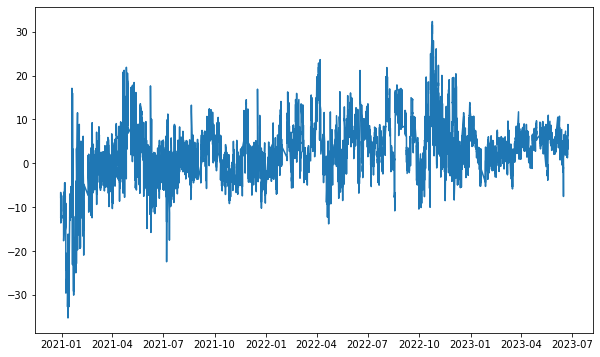

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(merged["diff_basis"])

merged["diff_basis"].mean()

Plotting both VN301FM and VN30 on the same graph for June 2023 maturity (from May 19 to June 15)

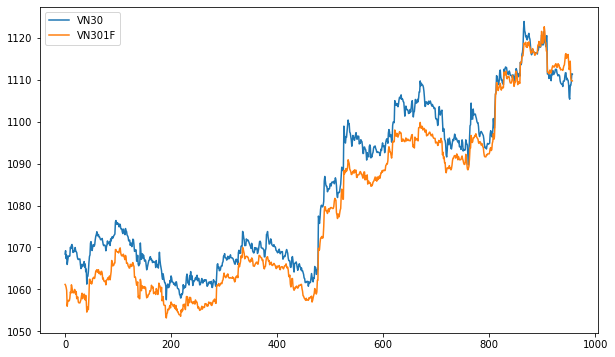

In [111]:
plt.figure(figsize=(10, 6))

time_frame = merged.loc["2023-05-19":"2023-06-15"]

plt.plot(time_frame['close_x'].values, label = "VN30")
plt.plot(time_frame['close_y'].values, label = "VN301F")

plt.legend()
plt.show() 

In [112]:
merged['contango'] = np.where(merged['diff_basis'] < 0, 1, 0)

In [113]:
merged['contango'].value_counts()

contango
0    19706
1     9767
Name: count, dtype: int64